In [67]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def f(x):
    return 3*x**2 - 4*x + 5

In [21]:
f(3.0)

20.0

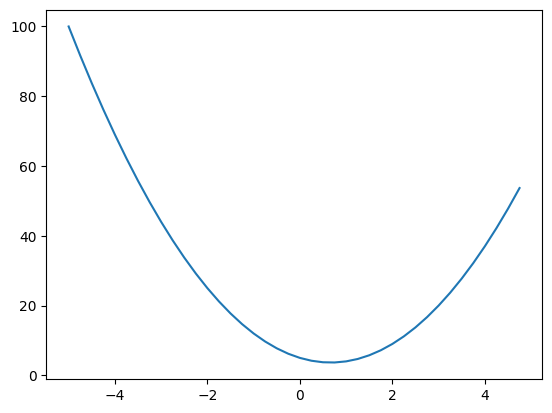

In [26]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [33]:
h = 0.00000001
x = 2 / 3
(f(x + h) - f(x)) / h

0.0

In [35]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [42]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [151]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other),'*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
        
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

e.label

'e'

In [72]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    nodes, edges = trace(root)
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

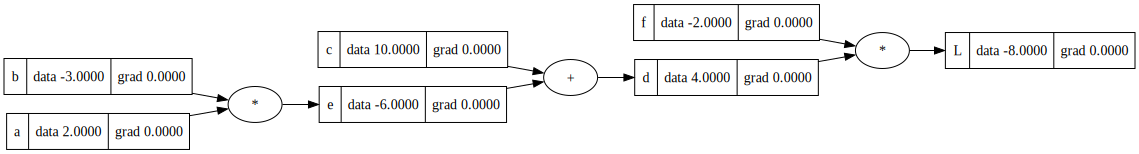

In [118]:
draw_dot(L)

In [59]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0 * 1
e.grad = -2.0 * 1
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0

In [74]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()


0.0


In [75]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

L.data

-8.0

In [152]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'
n = x1w1_x2w2 + b; n.label = 'n'
o = n.tanh()


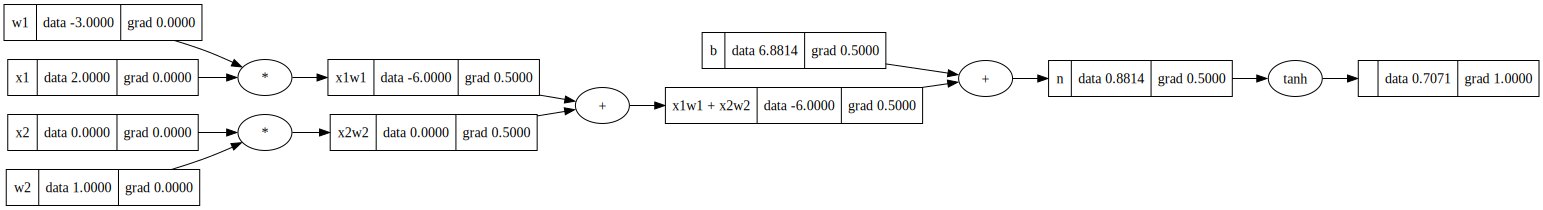

In [156]:
draw_dot(o)

In [153]:
o.grad = 1.0

In [154]:
o._backward()
n._backward()
b._backward()
x1w1_x2w2._backward()

In [155]:
x1w1._backward()
x2w2._backward()

In [101]:
# o = tanh(n)
# do/dn = 1 - o**2
1 - o.data**2

0.5000000000000306

In [106]:
o.grad = 1.0
n.grad = 0.5
x1w1_x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad